In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import copy
import time
from natsort import natsorted

# Task - 1

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [58]:
data_path = "/content/drive/MyDrive/3D_Vision/data"
images = []
image_filenames = []  # Store filenames corresponding to images

# Get a sorted list of image filenames
sorted_filenames = natsorted([img for img in os.listdir(data_path) if img.endswith(".png")])

for img in sorted_filenames:
    image_path = os.path.join(data_path, img)
    image = cv2.imread(image_path)

    if image is not None:
        images.append(image)
        image_filenames.append(img)

print(f"Total images loaded: {len(images)}")

Total images loaded: 200


## Feature Extraction

In [7]:
def sift(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

In [4]:
def orb(image):
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

In [16]:
def haris_feature_extractor(image, block_size=2, ksize=3, k=0.04):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    corners = cv2.cornerHarris(gray, block_size, ksize, k)

    # Convert corner response to keypoints
    keypoints = []
    for i in range(corners.shape[0]):
        for j in range(corners.shape[1]):
            if corners[i, j] > 0.01 * corners.max():  # Threshold for corner strength
                # Change _size to size
                keypoints.append(cv2.KeyPoint(x=float(j), y=float(i), size=1))

    return keypoints

In [44]:
def haris(image, method="SIFT"):
    """ Extract descriptors using Harris keypoints """
    keypoints = haris_feature_extractor(image)
    """ Compute descriptors for Harris keypoints using SIFT or ORB """
    if method == "SIFT":
        descriptor = cv2.SIFT_create()
    elif method == "ORB":
        descriptor = cv2.ORB_create()

    keypoints, descriptors = descriptor.compute(image, keypoints)
    return keypoints, descriptors

In [5]:
def draw_keypoints(image, keypoints, title="Keypoints"):
    # img_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    output_image = copy.deepcopy(image) # Changed from images to image
    for kp in keypoints:
      x, y = map(int, kp.pt)
      cv2.circle(output_image, (x, y), 2, (0, 0, 255), -1)
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

SIFT - Keypoints: 2928
ORB - Keypoints: 500
Harris - Keypoints: 3488


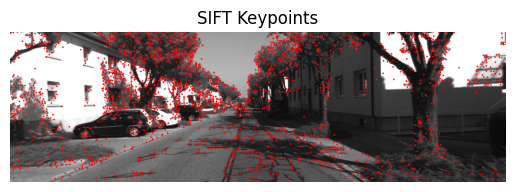

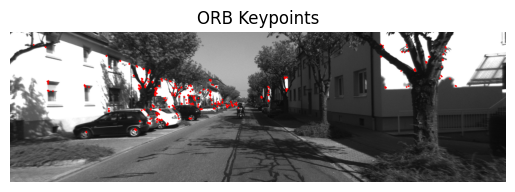

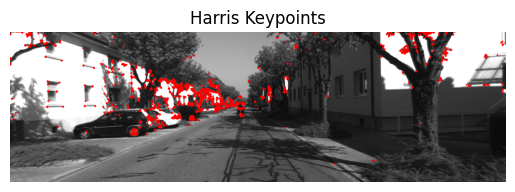

In [18]:
kp_sift, desc_sift = sift(images[0])
kp_orb, desc_orb = orb(images[0])
kp_harris = haris_feature_extractor(images[0])

print(f"SIFT - Keypoints: {len(kp_sift)}")
print(f"ORB - Keypoints: {len(kp_orb)}")
print(f"Harris - Keypoints: {len(kp_harris)}")

draw_keypoints(images[0], kp_sift, title=f"SIFT Keypoints")
draw_keypoints(images[0], kp_orb, title=f"ORB Keypoints")
draw_keypoints(images[0], kp_harris, title=f"Harris Keypoints")

## Feature Matching

In [27]:
# Brute Force Matching
def bf(desc1, desc2):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(desc1, desc2)
    return matches

In [78]:
# FLANN Matching
def flann(desc1, desc2):
    # Check if descriptors are of type uint8 (binary)
    if desc1.dtype == np.uint8:
        # For binary descriptors like ORB
        index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1)
    else:
        # For non-binary descriptors like SIFT
        index_params = dict(algorithm=1, trees=5) # Use kdtree for SIFT

    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desc1, desc2, k=2)
    return matches

In [83]:
def draw_matches(image1, image2, method):
    """
    Draws matches between two images using the specified feature extraction method.

    Args:
        image1: The first image.
        image2: The second image.
        method: The feature extraction method to use (e.g., sift, orb, haris).

    Returns:
        The output image with matches drawn.
    """
    # Feature Extraction
    # Extract keypoints and descriptors from both images using the provided method
    kp1, desc1 = method(image1)
    kp2, desc2 = method(image2)

    # Feature Matching
    # Find matches between descriptors using Brute-Force matcher
    matches = bf(desc1, desc2)

    # Create Output Image
    output_image = copy.deepcopy(image1)

    # RANSAC for Robust Matching
    # Extract coordinates of matched keypoints
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    # Find homography matrix using RANSAC to filter out outliers
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()  # Convert mask to a list

    # Keep only inlier matches
    final_matches = [m for m, keep in zip(matches, matchesMask) if keep]

    # Draw Keypoints and Matches
    # Draw all keypoints from the first image in red
    for kp in kp1:
        x, y = map(int, kp.pt)
        cv2.circle(output_image, (x, y), 2, (0, 0, 255), -1)

    # Draw inlier matches in green
    for match in final_matches:
        pt1 = tuple(map(int, kp1[match.queryIdx].pt))  # Point in the first image
        pt2 = tuple(map(int, kp2[match.trainIdx].pt))  # Corresponding point in the second image

        cv2.circle(output_image, pt1, 3, (0, 255, 0), -1)  # Draw a circle at the keypoint
        cv2.line(output_image, pt1, pt2, (0, 255, 0), 1)   # Draw a line connecting the keypoints

    return output_image

SIFT - Feature Maping:


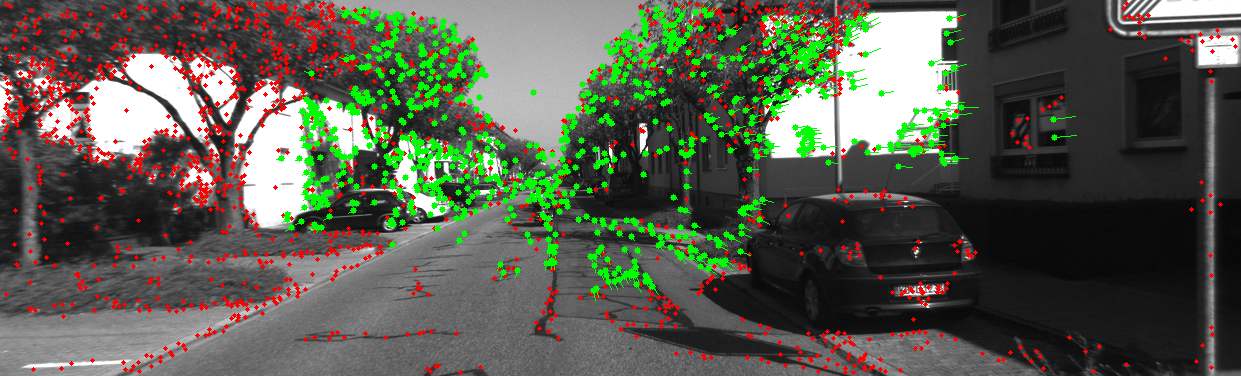

ORB - Feature Maping:


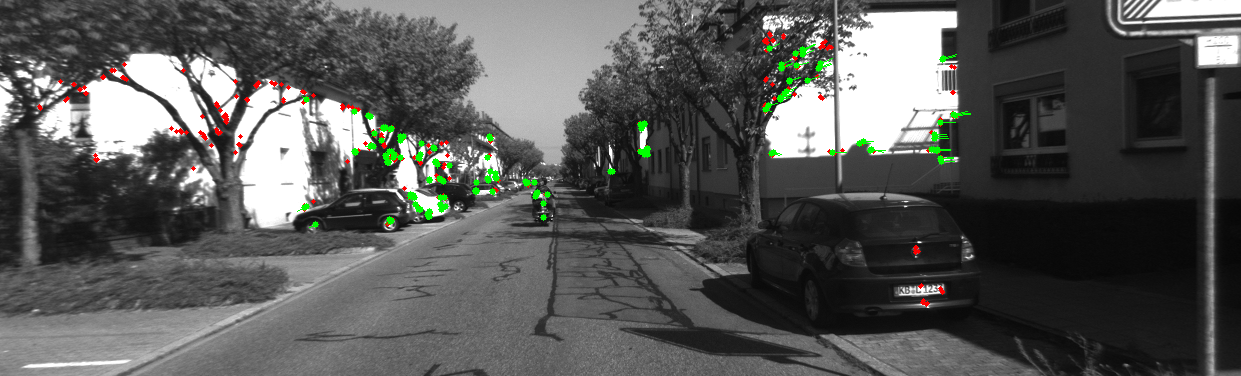

Harris - Feature Maping:


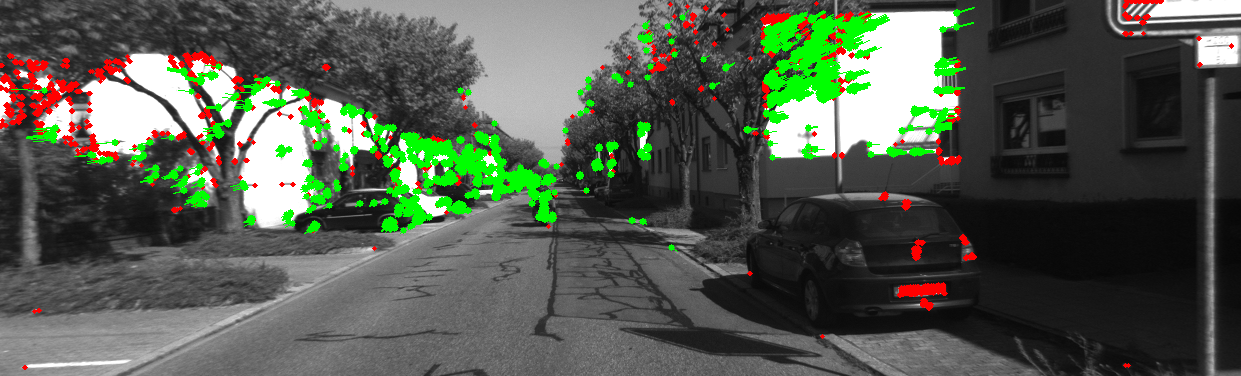

In [95]:
print("SIFT - Feature Maping:")
cv2_imshow(draw_matches(images[0], images[1], sift))

print("ORB - Feature Maping:")
cv2_imshow(draw_matches(images[0], images[1], orb))

print("Harris - Feature Maping:")
cv2_imshow(draw_matches(images[0], images[1], haris))

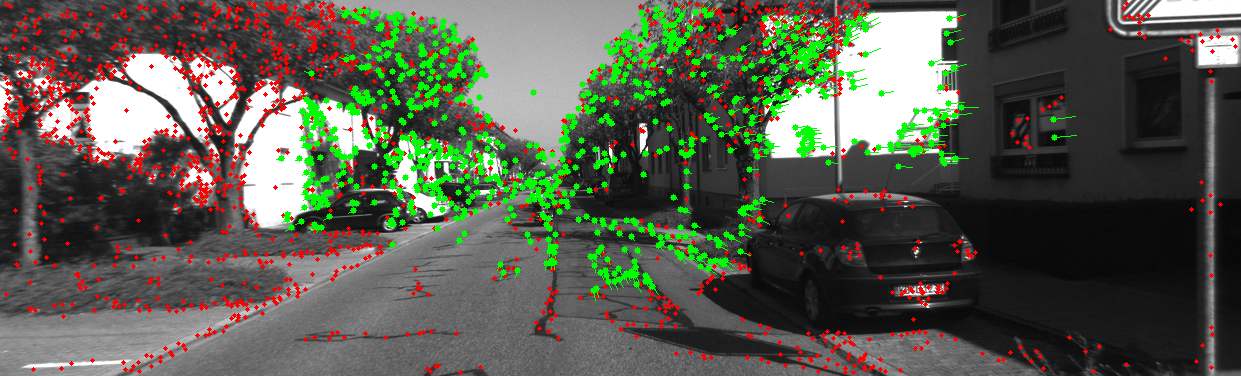

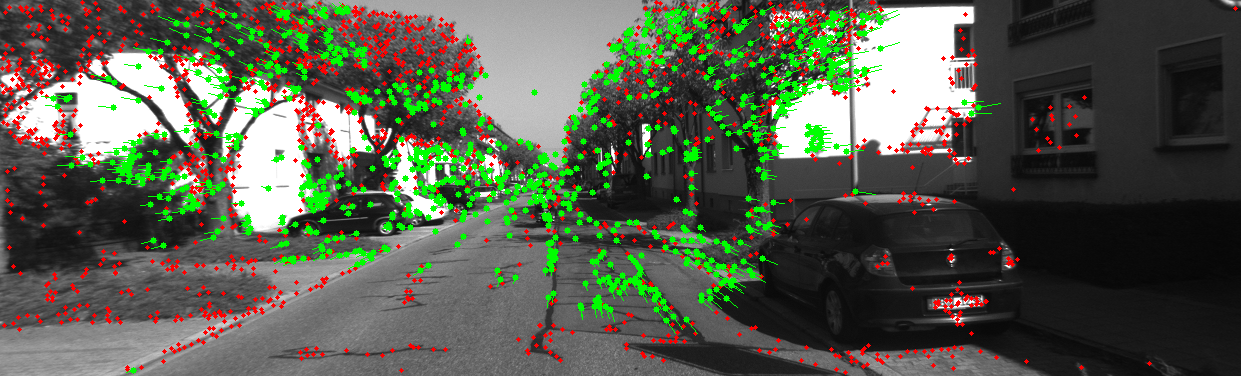

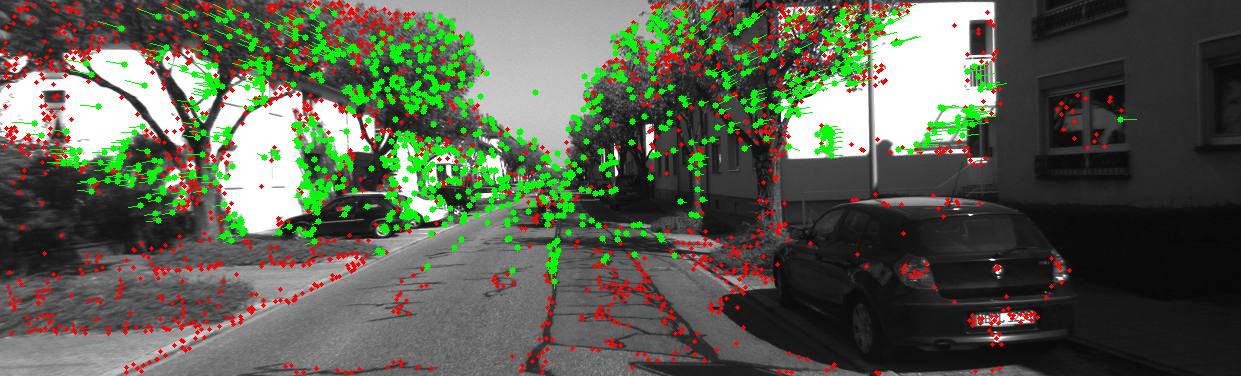

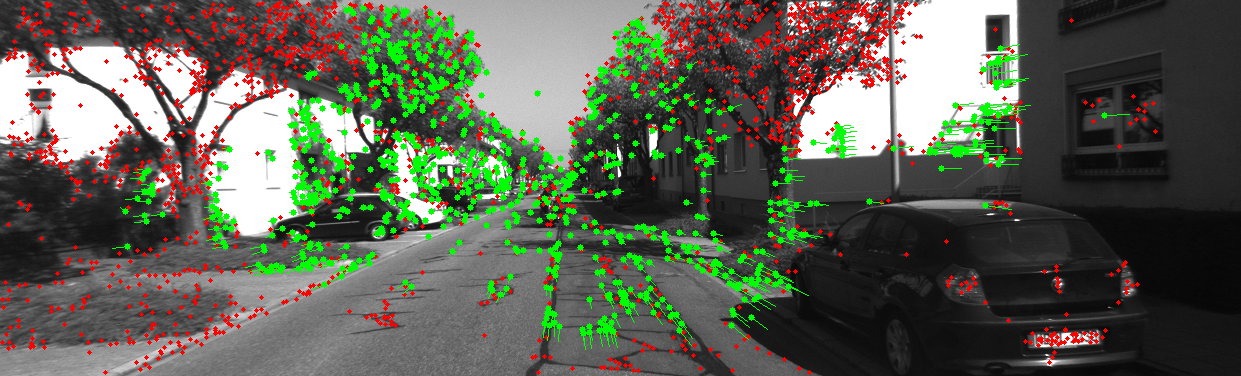

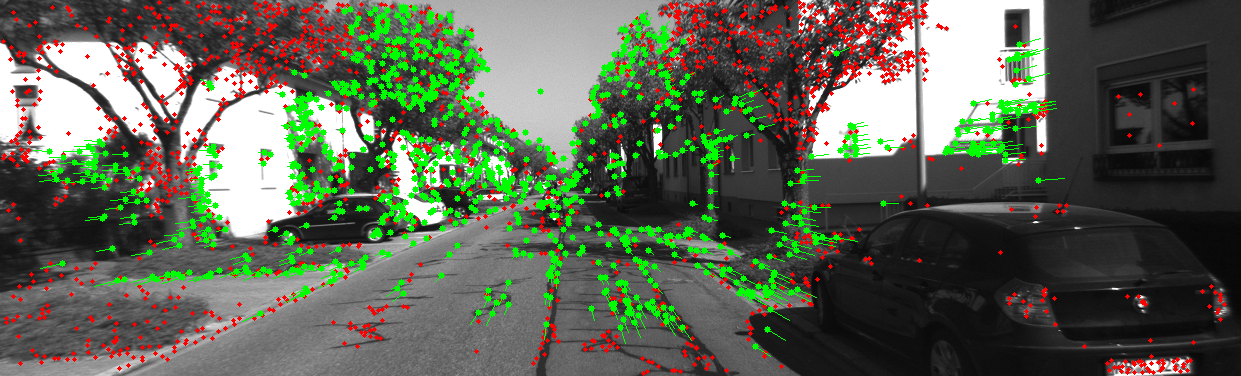

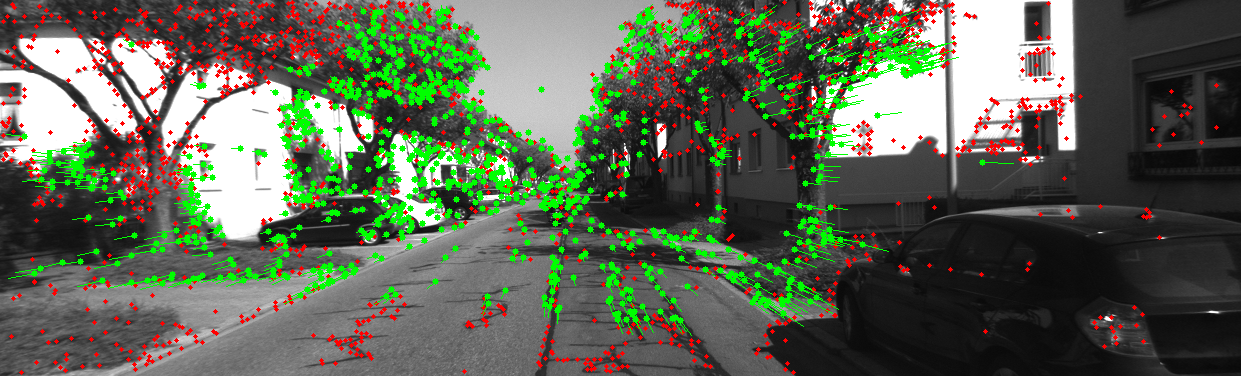

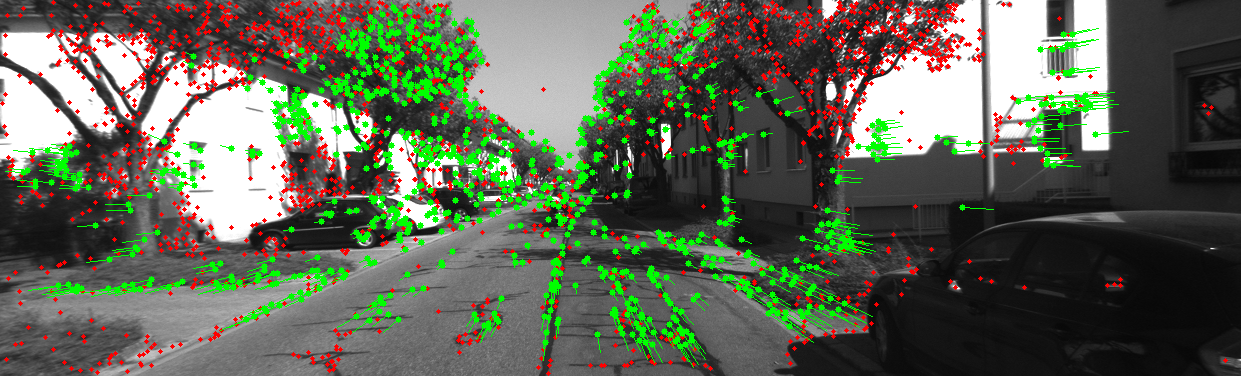

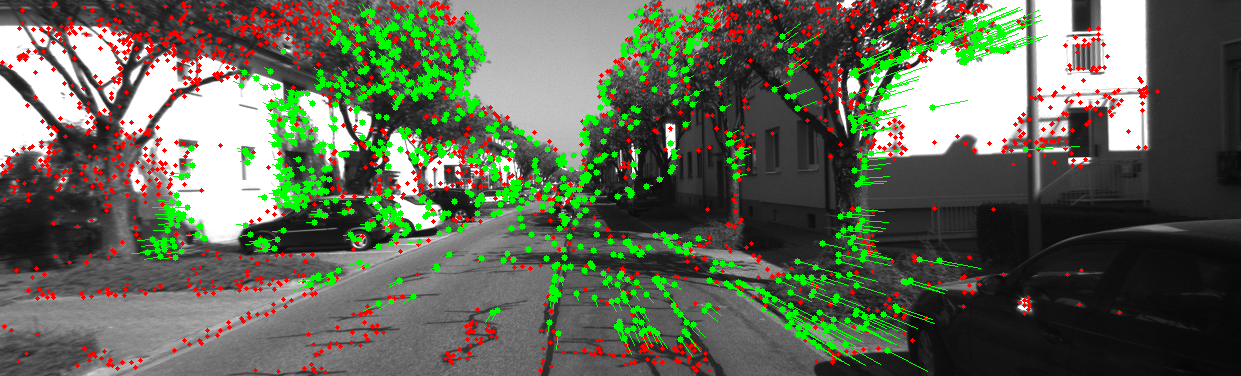

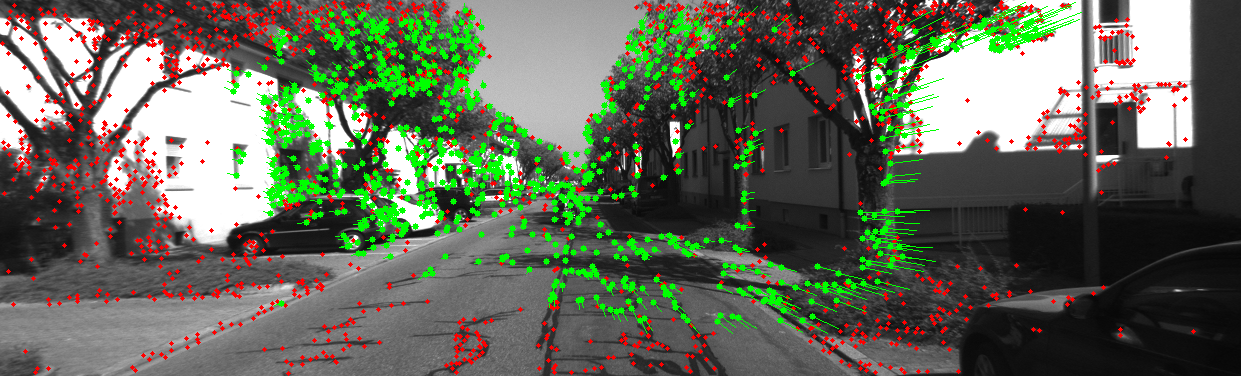

In [84]:
for i in range(9):
    cv2_imshow(draw_matches(images[i], images[i + 1], sift))

In [89]:
def create_video_from_images(images, method, output_path="output_video.avi", fps=10):
    """
    Creates a video from a sequence of images, applying feature matching between consecutive frames.

    Args:
        images: A list of images to include in the video.
        method: The feature extraction and matching method to use (e.g., sift, orb, haris).
        output_path: The path to save the output video file.
        fps: The frames per second for the video.
    """
    # Get the height and width of the first image to set the video frame size
    height, width, _ = images[0].shape

    # Define the video codec (XVID in this case) and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*"XVID")
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Iterate through the images, applying feature matching and writing to the video
    for i in range(len(images) - 1):
        # Apply feature matching between consecutive frames using the specified method
        matched_frame = draw_matches(images[i], images[i + 1], method)
        # Write the matched frame to the video
        out.write(matched_frame)

    # Release the VideoWriter to close the video file and save it
    out.release()

In [92]:
create_video_from_images(images[:25], sift, "sift_output.avi", fps=10)
create_video_from_images(images[:25], orb, "orb_output.avi", fps=10)
create_video_from_images(images[:25], haris, "harris_output.avi", fps=10)

In [93]:
create_video_from_images(images[:25], haris, "harris_output.avi", fps=10)

## Evaluate Methods

In [20]:
def evaluate_methods_bf(images, feature_extraction_method):
  # Dictionary to store landmark tracks across frames
  landmark_tracks = {}  # Key: initial keypoint, Value: list of subsequent keypoints
  min_consecutive_frames = 5  # Minimum frames a keypoint must persist to be a landmark

  # Variables to track performance metrics
  total_candidates = 0  # Total candidate keypoints detected
  total_time = 0  # Total processing time
  frame_count = len(images) - 1  # Number of frame pairs for processing

  # Iterate through consecutive frames to process keypoints and matches
  for frame_idx in range(1, frame_count + 1):
      start_time = time.time()  # Start time measurement for performance analysis

      # Extract keypoints and descriptors from two consecutive frames
      keypoints1, descriptors1 = feature_extraction_method(images[frame_idx - 1])
      keypoints2, descriptors2 = feature_extraction_method(images[frame_idx])

      # Accumulate total candidate keypoints detected
      total_candidates += len(keypoints2)

      # Match keypoints between the two frames using Brute Force mehod
      matches = bf(descriptors1, descriptors2)

      # Update landmark tracking by storing consecutive matched keypoints
      for match in matches:
          idx1 = match.queryIdx  # Index of the keypoint in the first frame
          idx2 = match.trainIdx  # Index of the keypoint in the second frame

          pt1 = tuple(map(int, keypoints1[idx1].pt))  # Convert keypoint to tuple (x, y)
          pt2 = tuple(map(int, keypoints2[idx2].pt))

          # If the keypoint is already tracked, append the new matched keypoint
          if pt1 in landmark_tracks:
              landmark_tracks[pt1].append(pt2)
          else:
              landmark_tracks[pt1] = [pt2]  # Initialize tracking for a new keypoint

      # Update total processing time for this iteration
      total_time += (time.time() - start_time)

  # Identify stable keypoints that persist across at least 'min_consecutive_frames'
  landmarks = [pt for pt, track in landmark_tracks.items() if len(track) >= min_consecutive_frames]

  # Compute average metrics across all processed frames
  avg_candidates = total_candidates / frame_count
  avg_time = total_time / frame_count

  # Print final results
  print(f"Average candidate points per frame: {avg_candidates:.2f}")
  print(f"Total number of landmarks: {len(landmarks)}")
  print(f"Total processing time: {total_time:.4f} seconds")

In [19]:
def evaluate_methods_flann(images, feature_extraction_method):
  # Dictionary to store landmark tracks across frames
  landmark_tracks = {}  # Key: initial keypoint, Value: list of subsequent keypoints
  min_consecutive_frames = 5  # Minimum frames a keypoint must persist to be a landmark

  # Variables to track performance metrics
  total_candidates = 0  # Total candidate keypoints detected
  total_time = 0  # Total processing time
  frame_count = len(images) - 1  # Number of frame pairs for processing

  # Iterate through consecutive frames to process keypoints and matches
  for frame_idx in range(1, frame_count + 1):
      start_time = time.time()  # Start time measurement for performance analysis

      # Extract keypoints and descriptors from two consecutive frames
      keypoints1, descriptors1 = feature_extraction_method(images[frame_idx - 1])
      keypoints2, descriptors2 = feature_extraction_method(images[frame_idx])

      # Accumulate total candidate keypoints detected
      total_candidates += len(keypoints2)

      # Match keypoints between the two frames using flann method
      matches = flann(descriptors1, descriptors2)

      # Update landmark tracking by storing consecutive matched keypoints
      # Iterate through the list of matches, each of which is a tuple of DMatch objects
      for match_list in matches:
          # Get the best match (the first element in the tuple)
          if match_list:  # Check if the match_list is not empty
              match = match_list[0]
              idx1 = match.queryIdx  # Index of the keypoint in the first frame
              idx2 = match.trainIdx  # Index of the keypoint in the second frame

              pt1 = tuple(map(int, keypoints1[idx1].pt))  # Convert keypoint to tuple (x, y)
              pt2 = tuple(map(int, keypoints2[idx2].pt))

              # If the keypoint is already tracked, append the new matched keypoint
              if pt1 in landmark_tracks:
                  landmark_tracks[pt1].append(pt2)
              else:
                  landmark_tracks[pt1] = [pt2]  # Initialize tracking for a new keypoint

      # Update total processing time for this iteration
      total_time += (time.time() - start_time)

  # Identify stable keypoints that persist across at least 'min_consecutive_frames'
  landmarks = [pt for pt, track in landmark_tracks.items() if len(track) >= min_consecutive_frames]

  # Compute average metrics across all processed frames
  avg_candidates = total_candidates / frame_count
  avg_time = total_time / frame_count

  # Print final results
  print(f"Average candidate points per frame: {avg_candidates:.2f}")
  print(f"Total number of landmarks: {len(landmarks)}")
  print(f"Total processing time: {total_time:.4f} seconds")

In [62]:
## SIFT Evaluation - using bf
evaluate_methods_bf(images, sift)

Average candidate points per frame: 2537.16
Total number of landmarks: 3309
Total processing time: 180.3815 seconds


In [63]:
## ORB Evaluation - using bf
evaluate_methods_bf(images, orb)

Average candidate points per frame: 500.00
Total number of landmarks: 489
Total processing time: 8.9501 seconds


In [94]:
## HARRIS Evaluation - using bf (only the first 20 images because running this method is very time-consuming)
evaluate_methods_bf(images[:20], haris)

Average candidate points per frame: 4864.68
Total number of landmarks: 1047
Total processing time: 1711.9952 seconds


In [77]:
## FLANN Evaluation - SIFT
evaluate_methods_flann(images, sift)

Average candidate points per frame: 2537.16
Total number of landmarks: 14711
Total processing time: 125.9359 seconds


In [69]:
## FLANN Evaluation - ORB
evaluate_methods_flann(images, orb)

Average candidate points per frame: 500.00
Total number of landmarks: 1738
Total processing time: 7.4082 seconds


# Task - 2

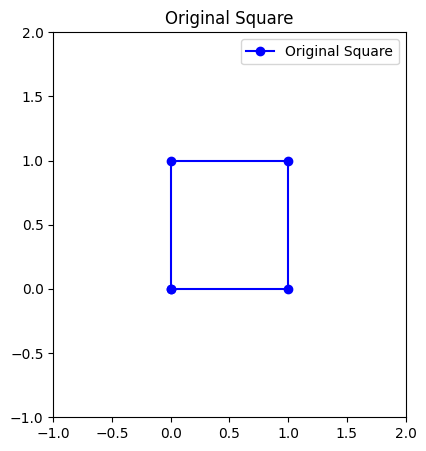

In [27]:
# Step 1: Define a square in 2D space
square = np.array([[0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]]).T  # 4 points in homogeneous coordinates

# Plot the original square
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], 'bo-', label="Original Square")
plt.xlim(-1, 2)
plt.ylim(-1, 2)
plt.title("Original Square")
plt.legend();

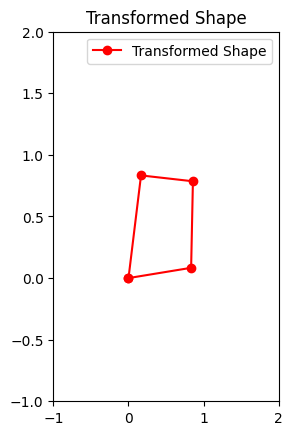

In [28]:
# Step 2: Apply a projective transformation
H = np.array([[1, 0.2, 0], [0.1, 1, 0], [0.2, 0.2, 1]])   # transformation matrix
transformed_square = H @ square  # Apply transformation
transformed_square /= transformed_square[2]  # Normalize

# Plot the transformed shape
plt.subplot(1, 2, 2)
plt.plot(transformed_square[0, [0, 1, 2, 3, 0]], transformed_square[1, [0, 1, 2, 3, 0]], 'ro-', label="Transformed Shape")
plt.xlim(-1, 2)
plt.ylim(-1, 2)
plt.title("Transformed Shape")
plt.legend()
plt.show()

In [48]:
def compute_vanishing_point(p1, p2, p3, p4):
    """ Compute the vanishing point given two lines defined by (p1, p2) and (p3, p4). """
    l1 = np.cross(p1, p2)  # Line 1
    l2 = np.cross(p3, p4)  # Line 2
    vp = np.cross(l1, l2)  # Intersection (vanishing point)
    if vp[2] == 0:
        print("Vanishing point is at infinity!")
        return  np.array([np.inf, np.inf, 1])

    return vp / vp[2]  # Convert to Cartesian coordinates

In [49]:
# Step 3: Compute the vanishing point for two parallel lines in the original shape
# Select two parallel lines (left and right vertical lines of the square)
vp_original = compute_vanishing_point(square[:, 0], square[:, 3], square[:, 1], square[:, 2])
print("Vanishing Point (Original Shape):", vp_original)

Vanishing point is at infinity!
Vanishing Point (Original Shape): [inf inf  1.]


In [47]:
# Step 4: Compute the vanishing point for the transformed shape
vp_transformed = compute_vanishing_point(transformed_square[:, 0], transformed_square[:, 3], transformed_square[:, 1], transformed_square[:, 2])
print("Vanishing Point (Transformed Shape):", vp_transformed)

Vanishing Point (Transformed Shape): [1. 5. 1.]


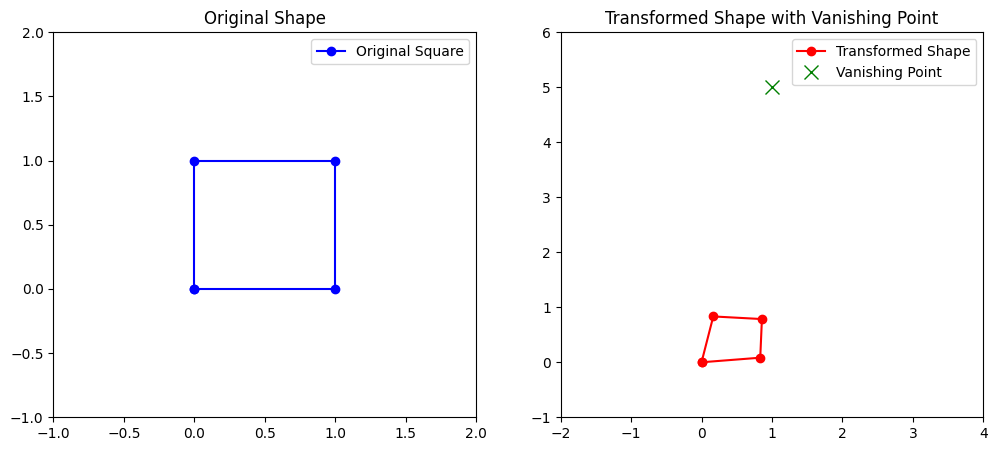

In [50]:
# Final visualization including vanishing points
plt.figure(figsize=(12, 5))

# Plot original square with vanishing point
plt.subplot(1, 2, 1)
plt.plot(square[0, [0, 1, 2, 3, 0]], square[1, [0, 1, 2, 3, 0]], 'bo-', label="Original Square")
plt.title("Original Shape")
plt.legend()
plt.xlim(-1, 2)
plt.ylim(-1, 2)

# Plot transformed shape with vanishing point
plt.subplot(1, 2, 2)
plt.plot(transformed_square[0, [0, 1, 2, 3, 0]], transformed_square[1, [0, 1, 2, 3, 0]], 'ro-', label="Transformed Shape")
if vp_transformed is not None:
    plt.plot(vp_transformed[0], vp_transformed[1], 'gx', markersize=10, label="Vanishing Point")
plt.title("Transformed Shape with Vanishing Point")
plt.legend()
plt.xlim(-2, 4)
plt.ylim(-1, 6)

plt.show()